In [ ]:
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import loader as load
import processor as pr
from torch.utils.data import Dataset, DataLoader

In [ ]:

target="tumor"
c="STAD"
data, files_names = load.loadAll(includeStage=(target=="stage"), sameSamples=True, skipGenes=True)
ge_genus, ge_genus_name = data[-1], files_names[-1]
ge_genus = load.attachTumorStatus(ge_genus)

x, y = pr.splitData(ge_genus, target=target, project=c)
x = x.drop(x.iloc[:, 5:5216], axis=1)
x

In [62]:
# https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

class OverlapDataset(Dataset):
    """Genus + GE dataset."""

    def __init__(self, target, cancer):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        data, files_names = load.loadAll(includeStage=(target=="stage"), sameSamples=True, skipGenes=True)
        ge_genus, ge_genus_name = data[-1], files_names[-1]

        if target=="tumor":
            ge_genus = load.attachTumorStatus(ge_genus)
        else:
            ge_genus = load.attachStageStatus(ge_genus)

        x, y = pr.splitData(ge_genus, target=target, project=cancer)
        x = x.drop(x.iloc[:, 20:5201], axis=1)
        
        self.modality_features = x
        self.targets = y


    def __len__(self):
        return len(self.modality_features)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample_features = self.modality_features.iloc[idx].values
        sample_target = self.targets.iloc[idx]
        sample = {'features': sample_features, 'target': sample_target}

        return sample

In [63]:
overlapped = OverlapDataset("tumor", "STAD")
# Display text and label.
print('\nFirst iteration of data set: ', next(iter(overlapped)), '\n')
# Print how many items are in the data set
print('Length of data set: ', len(overlapped), '\n')
# Print entire data set
print('Entire data set: ', list(DataLoader(overlapped))[:2], '\n')

# DataLoader is used to load the dataset
# for training
loader = torch.utils.data.DataLoader(dataset = overlapped,
									batch_size = 16,
									shuffle = True)
									
print('Batched data set: ', list(loader)[:2], '\n')


First iteration of data set:  {'features': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.75616629, 0.48675993, 0.44474001, 0.44796369,
       0.4937041 , 0.61874962, 0.46744023, 0.18409406, 0.3742703 ,
       0.52541865, 0.2518345 , 0.38613943, 0.77264123, 0.46519386,
       0.65618724, 0.77328287, 0.14825781, 0.18096101, 0.53191298]), 'target': 1} 

Length of data set:  122 

Entire data set:  [{'features': tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.7562, 0.4868, 0.4447, 0.4480, 0.4937, 0.6187,
         0.4674, 0.1841, 0.3743, 0.5254, 0.2518, 0.3861, 0.7726, 0.4652, 0.6562,
         0.7733, 0.1

In [64]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AE(torch.nn.Module):
	def __init__(self, input_features, hidden_features):
		super().__init__()
		
		# Building an linear encoder with Linear
		# layer followed by Relu activation function
		# 784 ==> 9
		self.encoder = torch.nn.Sequential(
			torch.nn.Linear(input_features, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, hidden_features)
		)
		
		# Building an linear decoder with Linear
		# layer followed by Relu activation function
		# The Sigmoid activation function
		# outputs the value between 0 and 1
		# 9 ==> 784
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(hidden_features, 18),
			torch.nn.ReLU(),
			torch.nn.Linear(18, 36),
			torch.nn.ReLU(),
			torch.nn.Linear(36, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, input_features),
			torch.nn.Sigmoid()
		)

	def forward(self, x):
		encoded = self.encoder(x)
		decoded = self.decoder(encoded)
		return encoded, decoded


In [65]:
# Model Initialization
model = AE(input_features=40, hidden_features=9)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 1e-1,
							weight_decay = 1e-8)

last hidden item:  tensor([ 0.1163,  0.4866, -0.1082, -0.2657, -0.1205, -0.4235, -0.4151,  0.2125,
        -0.1365], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1103,  0.4924, -0.1460, -0.2657, -0.1019, -0.4087, -0.3968,  0.2035,
        -0.1336], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1113,  0.5030, -0.1811, -0.2715, -0.0865, -0.4002, -0.3890,  0.2037,
        -0.1377], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1152,  0.5128, -0.2131, -0.2798, -0.0724, -0.3933, -0.3851,  0.2074,
        -0.1446], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1243,  0.5242, -0.2441, -0.2930, -0.0586, -0.3890, -0.3869,  0.2172,
        -0.1570], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1302,  0.5351, -0.2709, -0.3022, -0.0476, -0.3857, -0.3874,  0.2237,
        -0.1654], grad_fn=<SelectBackward0>)
last hidden item:  tensor([ 0.1332,  0.5455, -0.2940, -0.3078, -0.0389, -0.3832, -0.3865,  0.2273,
        -0.1704], grad_fn=<SelectBack

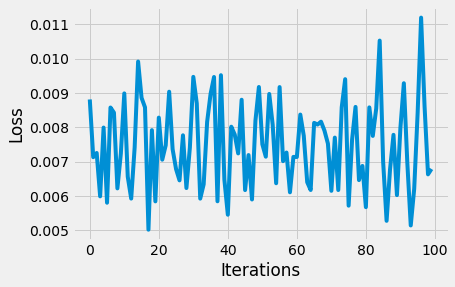

In [67]:
epochs = 100
outputs = []
losses = []
hidden_representation = None

for epoch in range(epochs):
	for batch_id, batched_samples in enumerate(loader):
		features = batched_samples["features"].float()
		
		# Output of Autoencoder
		hidden, reconstructed = model(features)
		
		# Calculating the loss function
		loss = loss_function(reconstructed, features)
		
		# The gradients are set to zero,
		# the gradient is computed and stored.
		# .step() performs parameter update
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Storing the losses in a list for plotting
		losses.append(loss.detach())
		outputs.append((epochs, features, reconstructed))
		hidden_representation = hidden[-1]

		print("last hidden item: ", hidden_representation)

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the last 100 values
plt.plot(losses[-100:])